# **Bank Account Fraud Detection Using Machine Learning**
### IT 7103 – Final Project (Part 2)
**Student:** Djuichou Kapawa Nounamo  
**Student ID:** 001122002

---

## **1. Introduction**
This project focuses on building a machine learning pipeline to detect fraudulent bank accounts using the NeurIPS 2022 Bank Account Fraud dataset. The dataset contains over 1.2 million rows and 35 features describing customer demographics, financial behavior, and account characteristics.

To ensure computational efficiency and fast hyperparameter tuning, this notebook uses a
**1.2% random subset** (~15,000 records) of the data, as permitted by project instructions.


### **Hypotheses**
1. Behavioral and financial features (e.g., income, balance, transaction count) will significantly influence fraud likelihood.
2. Ensemble models such as Random Forest and XGBoost will outperform Logistic Regression, especially on recall and F1-score, due to the imbalanced nature of fraud detection.
---

Loading The Data

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

dataset = pd.read_csv('/content/drive/MyDrive/Practical_data_analytics/Final_Project/Base.csv')
df = dataset.sample(frac=0.012, random_state=42)
print(f"Original dataset size: {dataset.shape}")
print(f"Subset size: {df.shape}")

df.head()


Original dataset size: (1000000, 32)
Subset size: (12000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
987231,0,0.1,0.218119,110,7,20,0.015684,-1.013463,AD,687,...,0,500.0,0,INTERNET,15.611467,windows,1,1,0,7
79954,0,0.1,0.373086,29,7,20,0.024277,19.342285,AA,1230,...,0,200.0,0,INTERNET,5.911984,other,0,1,0,0
567130,0,0.2,0.515218,-1,64,20,0.015865,-1.333985,AB,2045,...,1,200.0,0,INTERNET,4.732999,other,1,1,0,4
500891,0,0.6,0.899345,-1,56,20,0.018821,-1.524424,AC,1260,...,0,200.0,0,INTERNET,8.210518,linux,1,1,0,3
55399,0,0.9,0.794648,-1,64,50,0.027359,-1.254528,AB,1643,...,0,200.0,0,INTERNET,5.131610,other,0,1,0,0


In [127]:
df.shape

(12000, 32)

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 987231 to 888554
Data columns (total 32 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fraud_bool                        12000 non-null  int64  
 1   income                            12000 non-null  float64
 2   name_email_similarity             12000 non-null  float64
 3   prev_address_months_count         12000 non-null  int64  
 4   current_address_months_count      12000 non-null  int64  
 5   customer_age                      12000 non-null  int64  
 6   days_since_request                12000 non-null  float64
 7   intended_balcon_amount            12000 non-null  float64
 8   payment_type                      12000 non-null  object 
 9   zip_count_4w                      12000 non-null  int64  
 10  velocity_6h                       12000 non-null  float64
 11  velocity_24h                      12000 non-null  float64
 12  vel

Split dataset in train-test

In [129]:
from sklearn.model_selection import train_test_split
X = df.drop('fraud_bool', axis=1)
y = df['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))

Training set size: (9600, 31)
Test set size: (2400, 31)

Class distribution in training set:
fraud_bool
0    0.990417
1    0.009583
Name: proportion, dtype: float64


## **2. Preliminary Analysis**
This section provides exploratory data analysis including descriptive statistics,
distributions, correlations, and class balance visualization.

In [130]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
income,9600.0,0.558427,0.289943,0.100000,0.300000,0.600000,0.800000,0.900000
name_email_similarity,9600.0,0.492059,0.289183,0.001258,0.221985,0.489219,0.753311,0.999979
prev_address_months_count,9600.0,16.434375,43.792323,-1.000000,-1.000000,-1.000000,12.000000,354.000000
current_address_months_count,9600.0,86.554479,87.806208,-1.000000,20.000000,52.000000,131.000000,395.000000
customer_age,9600.0,33.788542,11.902610,10.000000,20.000000,30.000000,40.000000,90.000000
days_since_request,9600.0,1.025234,5.258359,0.000003,0.007240,0.015181,0.026452,74.746588
intended_balcon_amount,9600.0,9.003328,20.441082,-10.514480,-1.175469,-0.824241,9.264472,110.198097
zip_count_4w,9600.0,1576.045208,1014.049829,3.000000,898.000000,1263.500000,1943.250000,6321.000000
velocity_6h,9600.0,5644.015589,3010.617505,-24.645912,3387.811407,5300.725451,7663.151130,16162.247883
velocity_24h,9600.0,4773.428061,1473.787224,1439.639656,3593.783419,4745.937610,5776.144751,9324.326270


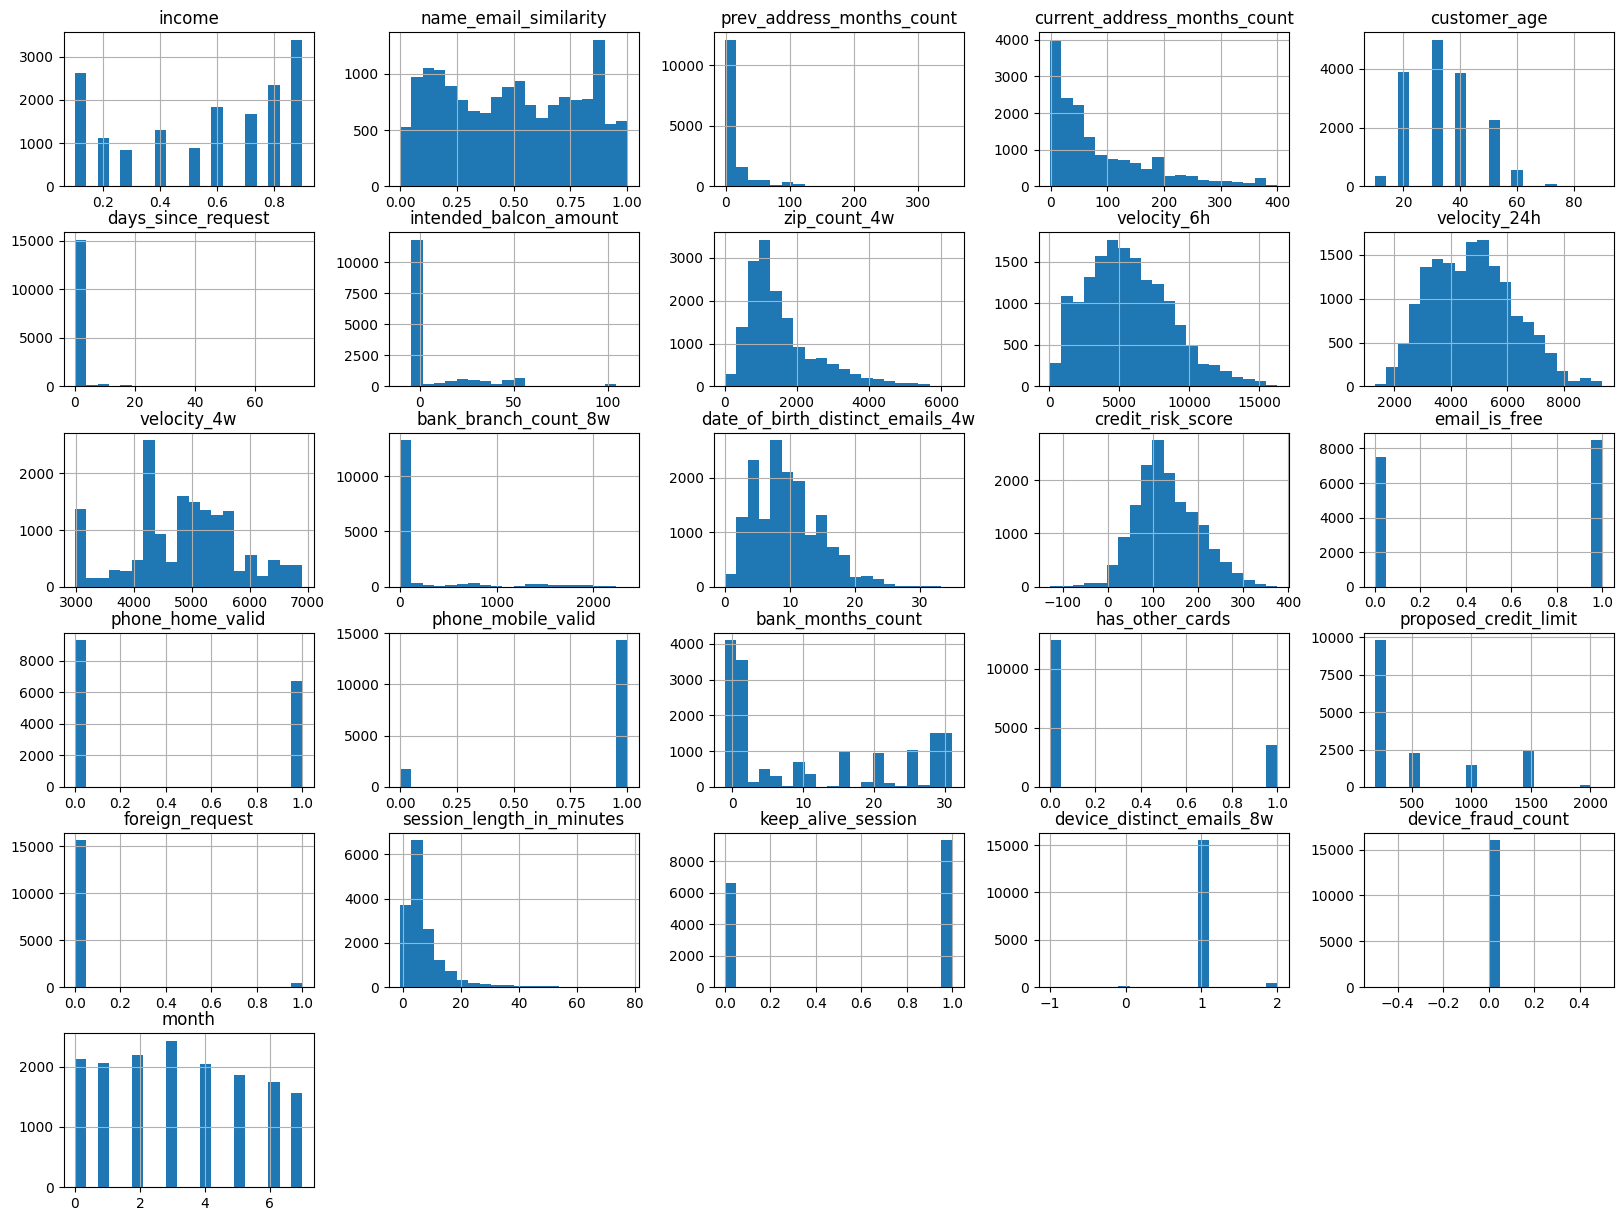

In [108]:
from matplotlib import pyplot as plt

X_train.hist(bins=20, figsize=(20,15))
plt.show()



Quite a few colums are skewed. We have to note them for the preprocessing steps. Also, **device_fraud_count** has a single value throughout all the rows, we will drop this later on.

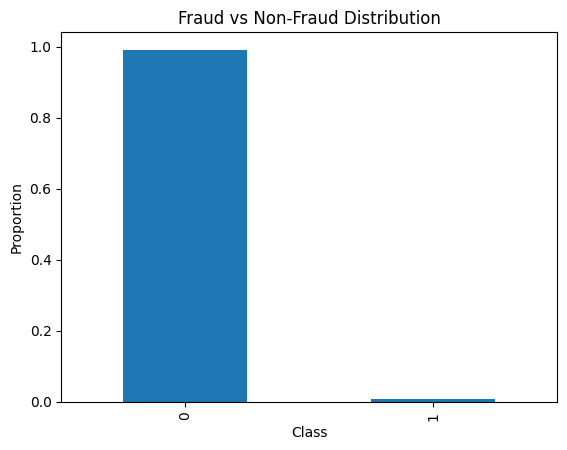

In [109]:
y_train.value_counts(normalize=True).plot(kind='bar')
plt.title('Fraud vs Non-Fraud Distribution')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.show()

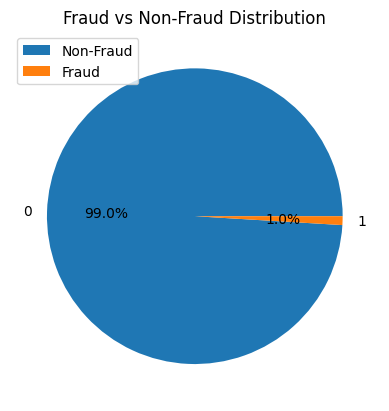

In [207]:
#percentage plot
y_train.value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Fraud vs Non-Fraud Distribution')
plt.ylabel('')
plt.legend(['Non-Fraud', 'Fraud'])
plt.show()


In [137]:
num_cols = [column for column in X_train.columns if (X_train[column].dtypes == np.int64) or (X_train[column].dtypes == np.float64)]
print(f"\nNumeric columns ({len(num_cols)}): {num_cols}")


Numeric columns (26): ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']


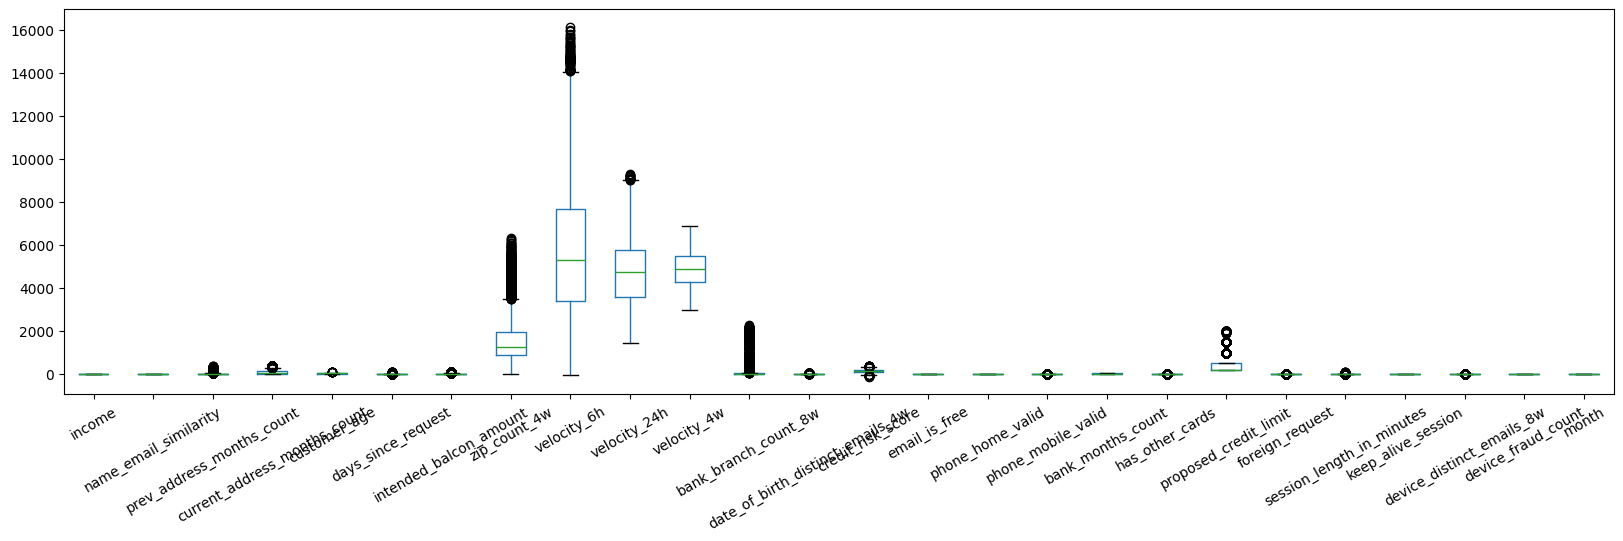

In [138]:
X_train[num_cols].boxplot(grid=False, figsize=(20,5),rot=30)
plt.show()

With this plot, we can see the numeric columns have very different ranges. This will need to be addressed by standardizing those columns in the preprocessing tasks.

In [139]:
cat_cols = [column for column in X_train.columns if X_train[column].dtypes == object]
print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")


Categorical columns (5): ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


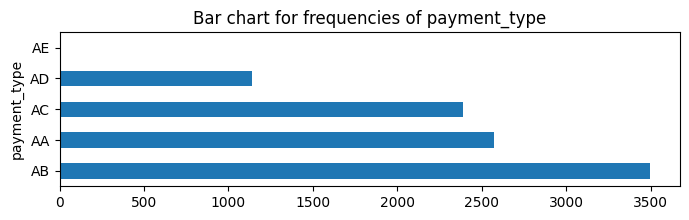

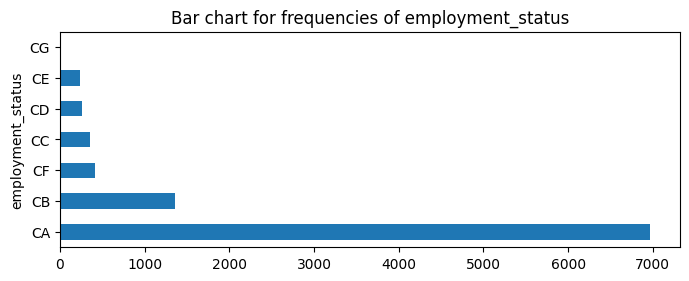

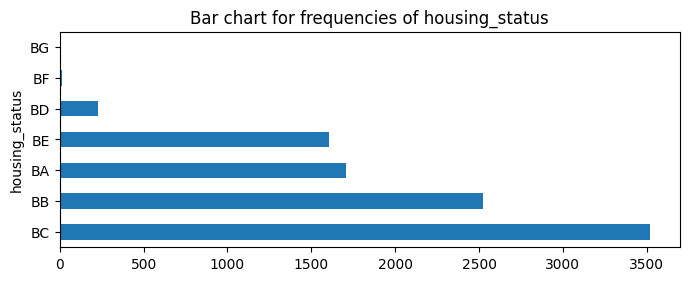

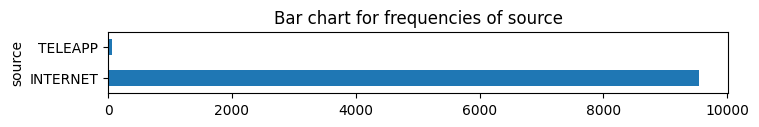

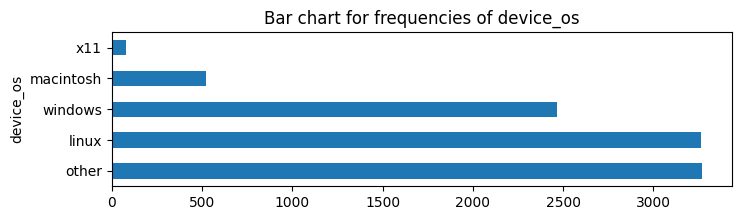

In [140]:
for col in cat_cols:
    freq_table = X_train[col].value_counts()
    plt.figure(figsize = (8,len(freq_table)*0.4)) #a bit formatting so that chart look better
    freq_table.plot.barh(title='Bar chart for frequencies of ' + col)
    plt.show()
    print()

Correlation Analysis

In [146]:
#Define Key numeric features for correlation
key_numeric = ['income', 'customer_age', 'credit_risk_score', 'proposed_credit_limit',
               'velocity_6h', 'velocity_24h', 'velocity_4w', 'session_length_in_minutes']
#Combine X_train and y_train for correlation
df_corr = pd.concat([X_train[key_numeric], y_train], axis=1)

correlation_matrix = df_corr.corr()
fraud_correlation = correlation_matrix['fraud_bool'].sort_values(ascending=False)
print("Top features correlated with fraud", fraud_correlation.head(10))




Top features correlated with fraud fraud_bool                   1.000000
credit_risk_score            0.065278
customer_age                 0.048641
proposed_credit_limit        0.047114
income                       0.036601
session_length_in_minutes    0.001053
velocity_24h                -0.003212
velocity_4w                 -0.015678
velocity_6h                 -0.025180
Name: fraud_bool, dtype: float64


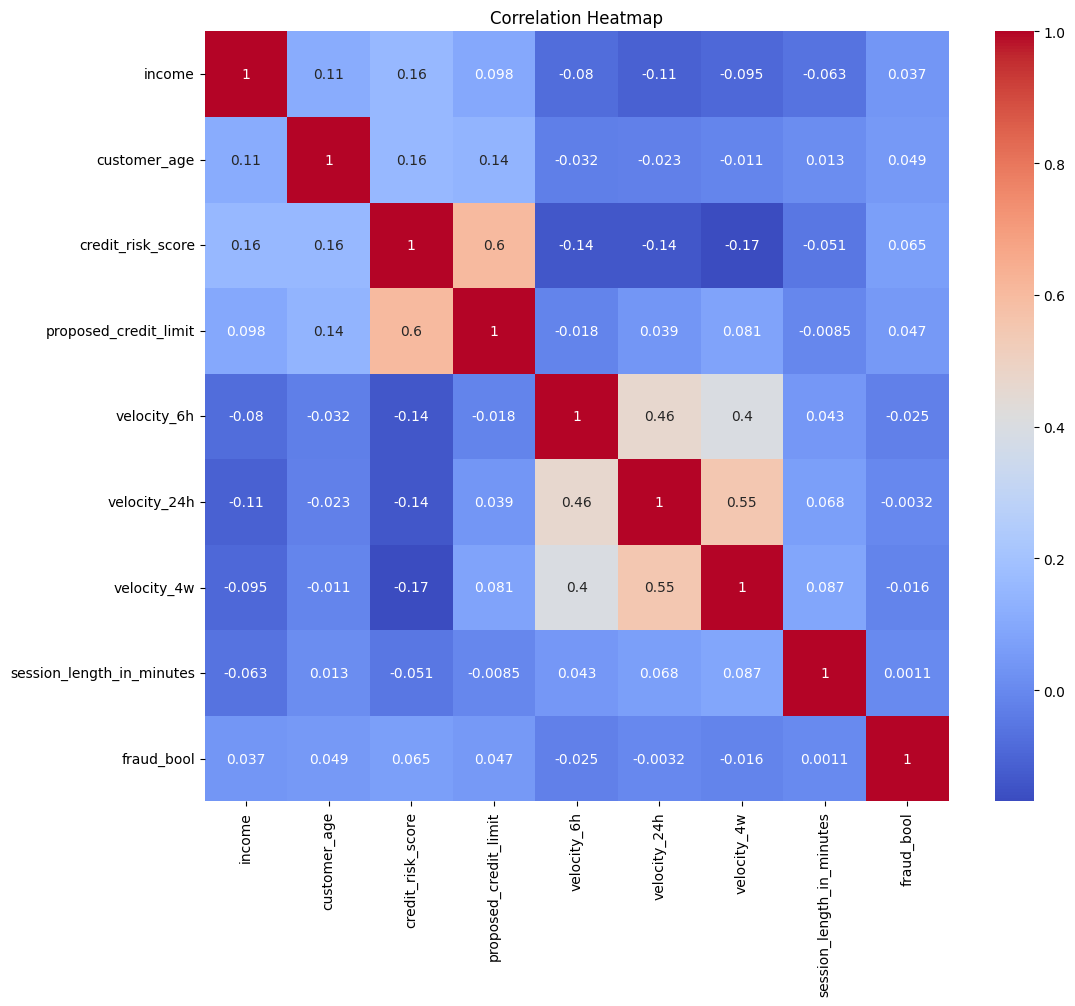

In [147]:
#Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## **3. Data Preprocessing**
This project applies the following preprocessing steps:
- Missing value imputation
* Log Transformations
- One-hot encoding of categorical variables
- Standard scaling
- Class imbalance handling using SMOTE











We will need to list colums for each type of transformation.

In [114]:
num_cols= ['income','name_email_similarity','customer_age','days_since_request',
          'velocity_6h','velocity_24h','velocity_4w','date_of_birth_distinct_emails_4w',
           'credit_risk_score','email_is_free','phone_home_valid','phone_mobile_valid',
           'has_other_cards','proposed_credit_limit','foreign_request',
           'keep_alive_session','device_distinct_emails_8w','month']

log_cols = ['prev_address_months_count','intended_balcon_amount','current_address_months_count',
            'zip_count_4w','bank_branch_count_8w','bank_months_count','session_length_in_minutes']

cat_cols =['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

### **Preprocessing Pipelines**

In [151]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

def handle_log_negatives(X):
    X_copy = X.copy()
    # Convert values that would make X+0.1 non-positive to NaN so imputer can handle them
    # This affects values where X <= -0.1
    X_copy[X_copy <= -0.1] = np.nan
    return X_copy

def log_transform(X):
    return np.log(X + 0.1)

log_pipeline = Pipeline([
    ('handle_negatives', FunctionTransformer(handle_log_negatives, validate=False)),
    ('impute', SimpleImputer(strategy='median')),
    ('log transform', FunctionTransformer(log_transform, validate=False)),
    ('standardize', StandardScaler())
])


categorical_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipeline,  num_cols),
    ('log', log_pipeline, log_cols),
    ('cat', categorical_transform, cat_cols)
],remainder='drop')

In [152]:
preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['income', 'name_email_similarity',
                                  'prev_address_months_count',
                                  'current_address_months_count',
                                  'customer_age', 'days_since_request',
                                  'intended_balcon_amount', 'zip_count_4w',
                                  'velocity_6h', 'velocity_24h', 'velocity_4w',
                                  'bank_br...
                                 ['prev_address_months_count',
                                  'intended_balcon_amount',
                                  'current_address_months_count',
                                  'zip_count_4w', 'bank_branch_count_8w',
                                  'bank_months_count',
                                  'session_length_in_minutes']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['payment_type', 'employment_status',
                                  'housing_status', 'source', 'device_os'])])

## **4. Model Selection, Training, & Hyperparameter Search**
This is a classification problem.We will try Three different models:
- Logistic Regression
- Random Forest
- XGBoost


Logistic Regression

In [180]:
baseline_results= {}

In [181]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import FunctionTransformer

logistic_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

logistic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'prev_address_months_count',
                                                   'current_address_months_count',
                                                   'customer_age',
                                                   'days_since_request',
                                                   'intended_balcon_amount',
                                                   'zip_count_4w',
                                                   'velocity_6h',
                                                   'veloci...
                                                   'bank_branch_count_8w',
                                                   'bank_months_count',
                                                   'session_length_in_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['payment_type',
                                                   'employment_status',
                                                   'housing_status', 'source',
                                                   'device_os'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [182]:
logistic_pred_train = logistic_pipeline.predict(X_train)

from sklearn.metrics import accuracy_score
lr_acc_train= accuracy_score(y_train,logistic_pred_train)
baseline_results['Logistic Regression'] = lr_acc_train
print(f"Training Accuracy: {lr_acc_train}")

Training Accuracy: 0.8490625


Random Forest

In [183]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'prev_address_months_count',
                                                   'current_address_months_count',
                                                   'customer_age',
                                                   'days_since_request',
                                                   'intended_balcon_amount',
                                                   'zip_count_4w',
                                                   'velocity_6h',
                                                   'veloci...
                                                   'bank_branch_count_8w',
                                                   'bank_months_count',
                                                   'session_length_in_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['payment_type',
                                                   'employment_status',
                                                   'housing_status', 'source',
                                                   'device_os'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [184]:
rf_pred_train= rf_pipeline.predict(X_train)
rf_acc_train=accuracy_score(y_train,rf_pred_train)
baseline_results['Random Forest'] = rf_acc_train
print(f"Training Accuracy: {rf_acc_train}")

Training Accuracy: 1.0


This accuracy rate means that 100% of train data is predicted with the correct labels, this might be a sign of potential overfitting problem.

XGBoost

In [185]:
from xgboost import XGBClassifier
xgb_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(tree_method='hist', random_state=42, n_jobs=-1, eval_metric='logloss'))
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['income',
                                                   'name_email_similarity',
                                                   'prev_address_months_count',
                                                   'current_address_months_count',
                                                   'customer_age',
                                                   'days_since_request',
                                                   'intended_balcon_amount',
                                                   'zip_count_4w',
                                                   'velocity_6h',
                                                   'veloci...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [186]:
xgb_pred_train = xgb_pipeline.predict(X_train)
xgb_acc_train= accuracy_score(y_train,xgb_pred_train)
baseline_results['XGBoost'] = xgb_acc_train
print(f"Training Accuracy: {xgb_acc_train}")

Training Accuracy: 1.0


This accuracy rate means that 100% of train data is predicted with the correct labels, this might be a sign of potential overfitting problem.




<Axes: xlabel='Model', ylabel='Accuracy'>

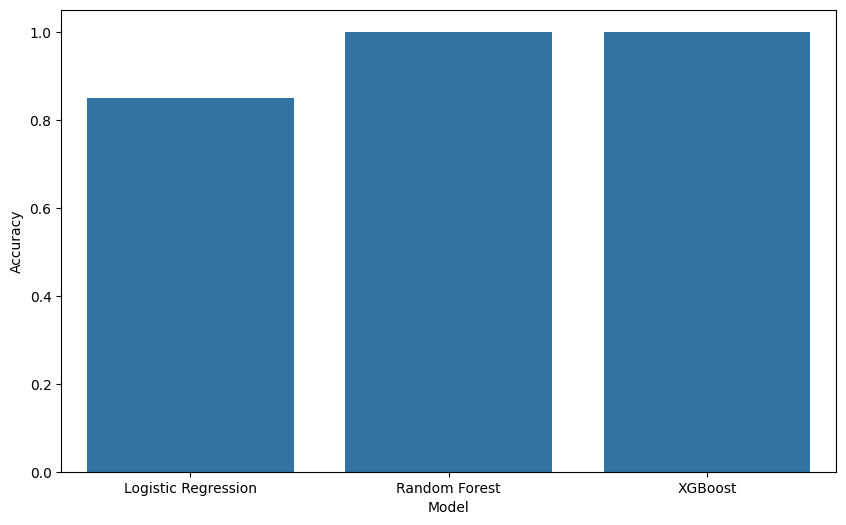

In [187]:
#Visualize Baseline results
baseline_df = pd.DataFrame(list(baseline_results.items()), columns=['Model', 'Accuracy'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=baseline_df)


**Finetuning the modelS**

The three models we have trained are only with their default setting which are not optimal most of the times,

In [188]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#Define parameter grids
param_lr = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

param_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__max_features': ['sqrt', 'log2']
}

param_xgb = {
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__n_estimators': [100, 200],
    'clf__subsample': [0.8, 1.0]
}

models = {
    'Logistic Regression': (logistic_pipeline, param_lr),
    'Random Forest': (rf_pipeline, param_rf),
    'XGBoost': (xgb_pipeline, param_xgb)
}

In [189]:
# Perform GridSearchCV
best_models = {}
tuning_results = []

from sklearn.metrics import classification_report, roc_auc_score

for name, (pipe, params) in models.items():
    print(f"\n----- Running GridSearch for {name} -----")
    grid = GridSearchCV(pipe, params, scoring='f1', cv=3, n_jobs=-1,verbose=1)

    grid.fit(X_train, y_train)
    best_models[name] = grid

    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best F1 score: {grid.best_score_:.4f}")

    tuning_results.append({
        'Model': name,
        'Best F1 (CV)': grid.best_score_,
        'Best Params': str(grid.best_params_)
    })


----- Running GridSearch for Logistic Regression -----
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params for Logistic Regression: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best F1 score: 0.0797

----- Running GridSearch for Random Forest -----
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for Random Forest: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best F1 score: 0.1332

----- Running GridSearch for XGBoost -----
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best params for XGBoost: {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Best F1 score: 0.1040


In [191]:
# Display tuning results
tuning_df = pd.DataFrame(tuning_results)
print(tuning_df.to_string(index=False))

              Model  Best F1 (CV)                                                                                                Best Params
Logistic Regression      0.079666                                             {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
      Random Forest      0.133201 {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
            XGBoost      0.104044         {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'clf__subsample': 1.0}


## **5. Evaluation, Results & Analysis**
In this section, we evaluate all models on the test set using multiple metrics:
- Accuracy
- Precision, Recall, F1-Score(focusing on Fraud class)
- ROC-AUC
- Confusion Matrix

We also perform:
- Feature importance analysis (Hypothesis 1)
- Model comparison (Hypothesis 2)


In [192]:
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)

#Test set evaluation
evaluation_results = []

for name, model in best_models.items():
  print(f"Model: {name}")

  #Predictions
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:, 1]

  #Metrics
  accuracy = accuracy_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred_proba)

  print(f"\nAccuracy: {accuracy:.4f}")
  print(f"ROC-AUC: {roc_auc:.4f}")
  print(f"\nClassification Report:")
  print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraud']))

  #Store results
  report_dict = classification_report(y_test, y_pred, output_dict=True)
  evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision (Fraud)': report_dict['1']['precision'],
        'Recall (Fraud)': report_dict['1']['recall'],
        'F1-Score (Fraud)': report_dict['1']['f1-score'],
        'ROC-AUC': roc_auc
  })

#Create results dataframe
results_df = pd.DataFrame(evaluation_results)
print("\n" + "=" * 80)
print("MODEL EVALUATION SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))


Model: Logistic Regression

Accuracy: 0.8483
ROC-AUC: 0.7982

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.85      0.92      2377
       Fraud       0.03      0.52      0.06        23

    accuracy                           0.85      2400
   macro avg       0.51      0.69      0.49      2400
weighted avg       0.99      0.85      0.91      2400

Model: Random Forest

Accuracy: 0.9767
ROC-AUC: 0.7753

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.98      0.99      2377
       Fraud       0.13      0.26      0.18        23

    accuracy                           0.98      2400
   macro avg       0.56      0.62      0.58      2400
weighted avg       0.98      0.98      0.98      2400

Model: XGBoost

Accuracy: 0.9633
ROC-AUC: 0.7364

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.99      0.97      0.98      2377


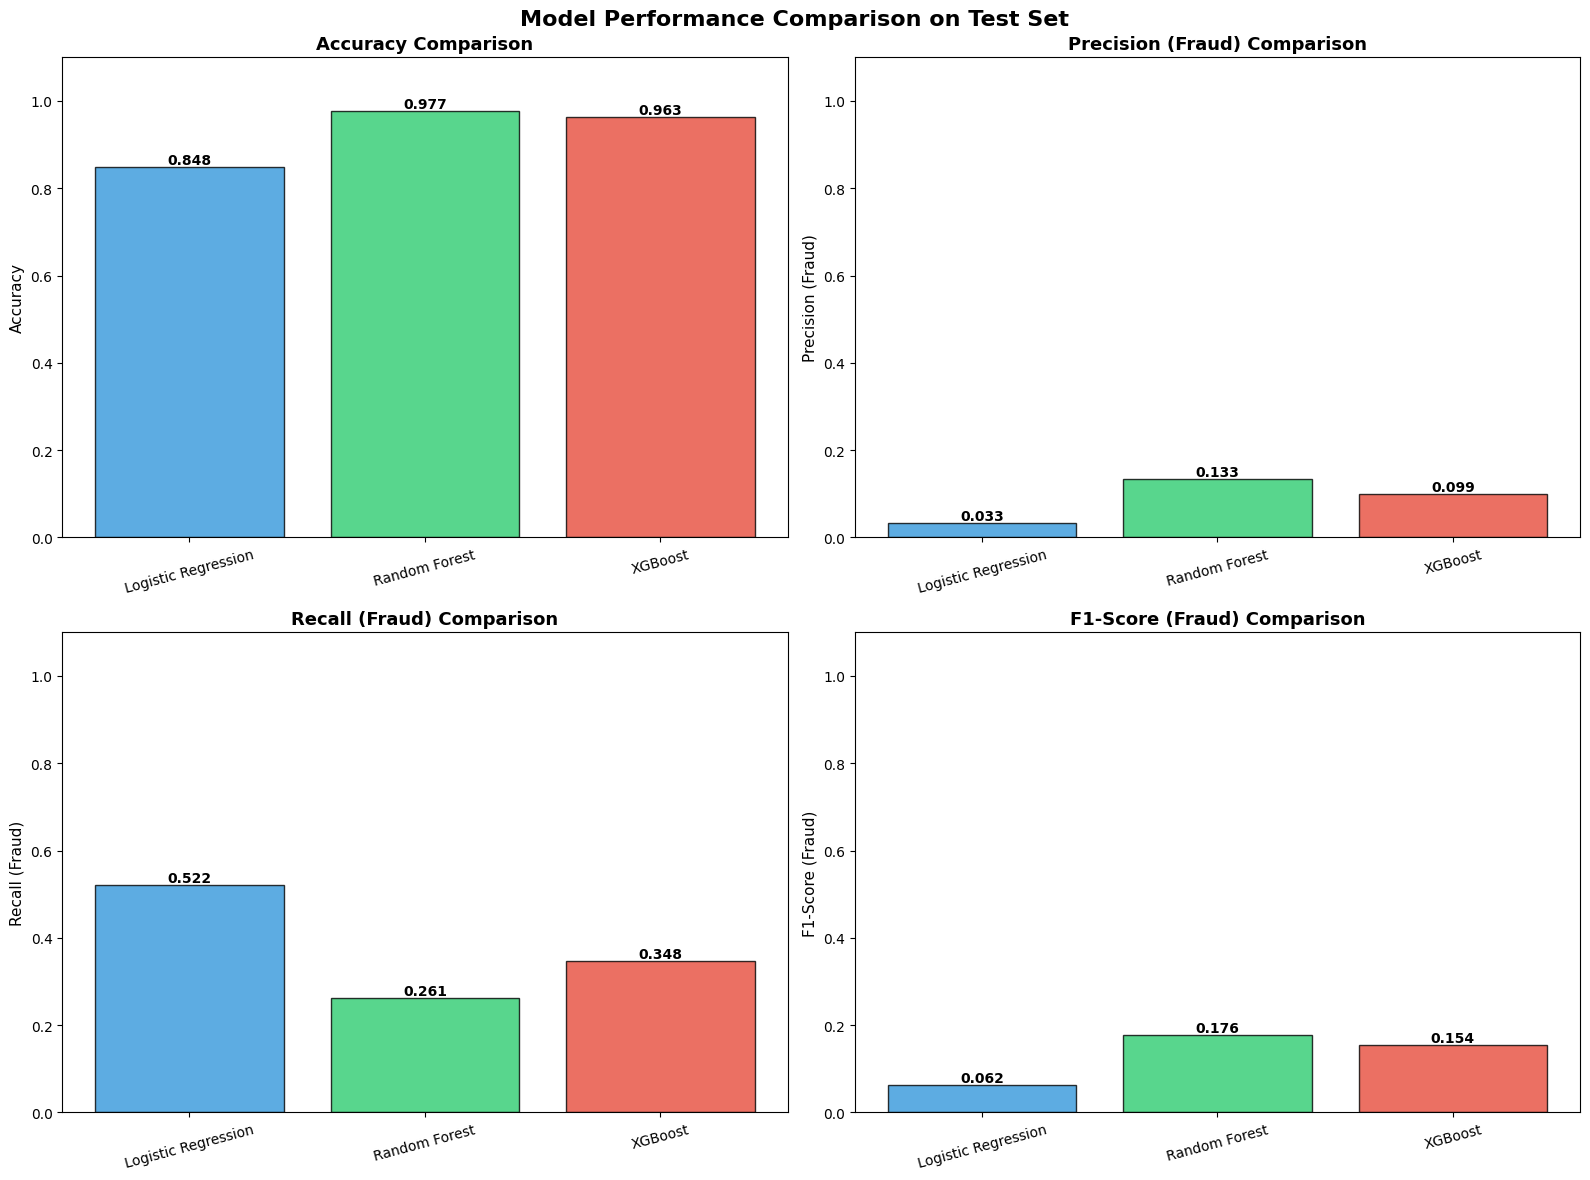

In [195]:
#Visualize model comparison for accuracy, precision(fraud),recall(fraud),F1-score(fraud)
metrics = ['Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)']
colors = ['#3498db', '#2ecc71', '#e74c3c']

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
for idx, metric in enumerate(metrics):
    ax = axs[idx // 2, idx % 2]
    values = results_df[metric].values
    bars = ax.bar(results_df['Model'], values, color=colors, edgecolor='black', alpha=0.8)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1.1])
    ax.tick_params(axis='x', rotation=15)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Performance Comparison on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()





Base on this plot, we can say that the best model is **Random Forest**, since it has the highest **F1_score** which 0.176.

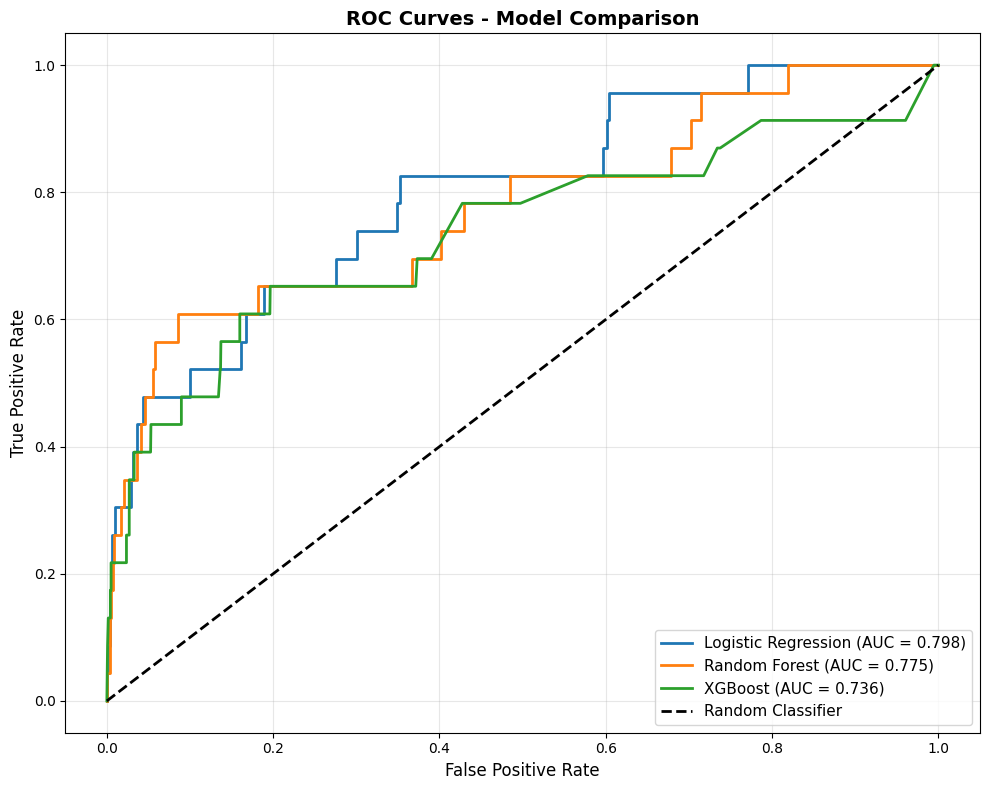

In [196]:
#ROC Curves
plt.figure(figsize=(10, 8))

for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

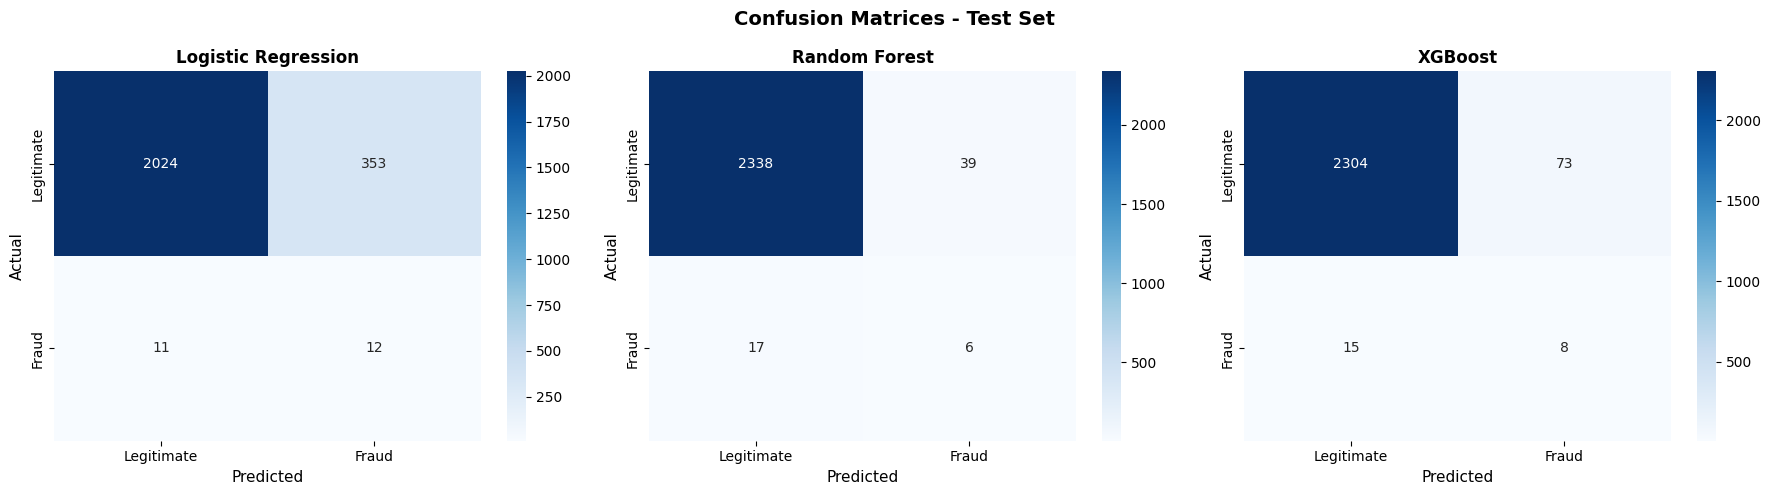

In [198]:
#Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(best_models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

plt.suptitle('Confusion Matrices - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

To verify if Hypothesis 1 was correct, we decided to extract feature importance from the best model, which in this case is Random Forest.


Top 15 Most Important Features (Random Forest):
 1. housing_status_BA                        : 0.1824
 2. keep_alive_session                       : 0.0739
 3. phone_home_valid                         : 0.0615
 4. device_os_windows                        : 0.0502
 5. housing_status_BB                        : 0.0483
 6. customer_age                             : 0.0414
 7. device_os_linux                          : 0.0402
 8. housing_status_BC                        : 0.0346
 9. current_address_months_count             : 0.0306
10. payment_type_AC                          : 0.0289
11. proposed_credit_limit                    : 0.0273
12. has_other_cards                          : 0.0263
13. bank_months_count                        : 0.0260
14. credit_risk_score                        : 0.0253
15. email_is_free                            : 0.0251


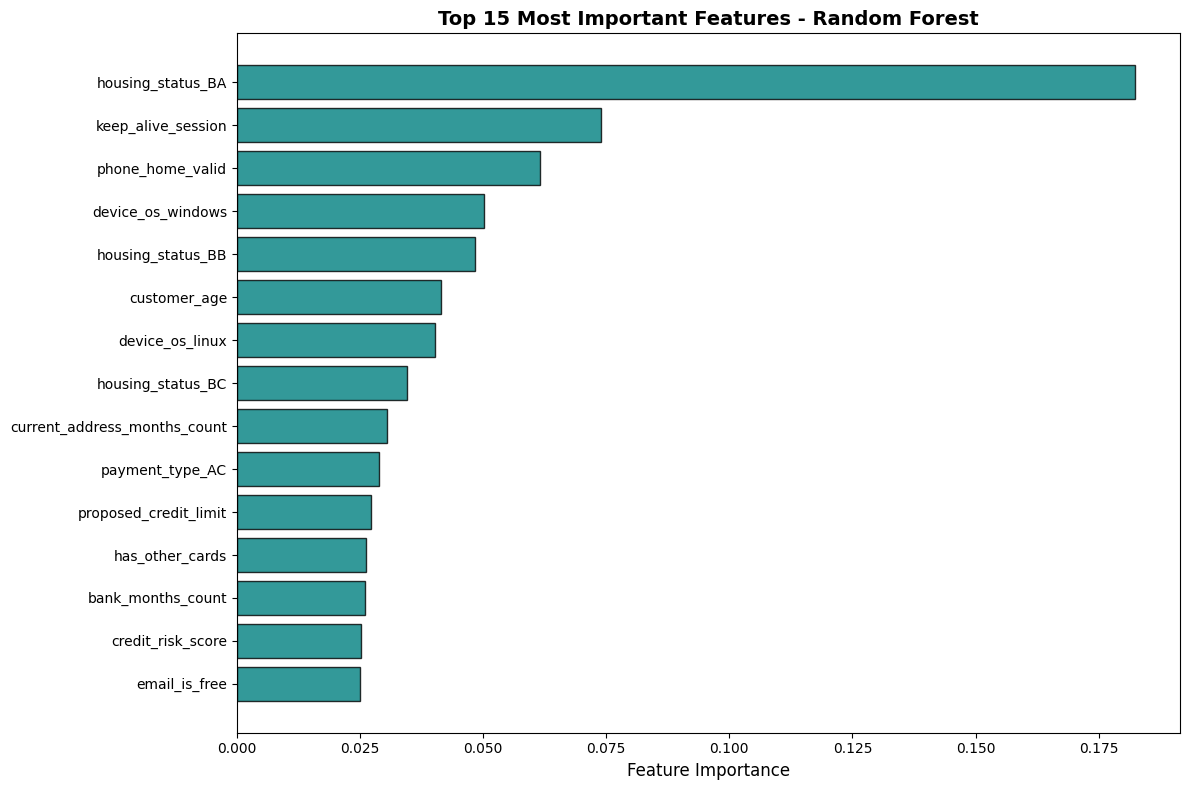

In [200]:
# FEATURE IMPORTANCE ANALYSIS (HYPOTHESIS 1)
# Extract feature importance from Random Forest
rf_model = best_models['Random Forest'].best_estimator_
rf_preprocessor = rf_model.named_steps['preprocess']
rf_classifier = rf_model.named_steps['clf']

# Get feature names after preprocessing
feature_names = []

# Numeric features
feature_names.extend(num_cols)

# Log-transformed features
feature_names.extend(log_cols)

# One-hot encoded features
if 'cat' in rf_preprocessor.named_transformers_:
    cat_encoder = rf_preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = cat_encoder.get_feature_names_out(cat_cols)
    feature_names.extend(cat_feature_names)

# Get importances
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Top 15 features
top_n = 15
top_indices = indices[:top_n]
top_features = [feature_names[i] for i in top_indices]
top_importances = importances[top_indices]

print(f"\nTop {top_n} Most Important Features (Random Forest):")
for i, (feat, imp) in enumerate(zip(top_features, top_importances), 1):
    print(f"{i:2d}. {feat:40s} : {imp:.4f}")

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_importances[::-1], color='teal', edgecolor='black', alpha=0.8)
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel('Feature Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features - Random Forest', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [204]:
# Hypothesis 1 verification
behavioral_features = ['income', 'velocity_24h', 'velocity_6h', 'velocity_4w',
                       'credit_risk_score', 'has_other_cards', 'proposed_credit_limit',
                       'customer_age', 'current_address_months_count', 'payment_type_AC']
behavioral_in_top = [f for f in top_features if any(bf in f for bf in behavioral_features)]

print(f"Behavioral/financial features in top {top_n}:")
for feat in behavioral_in_top:
    print(f"  ✓ {feat}")

if len(behavioral_in_top) >= 3:
    print(f"\n✓ HYPOTHESIS 1 SUPPORTED: {len(behavioral_in_top)} behavioral/financial features")
    print("  appear in the top 15, confirming their strong influence on fraud detection.")
else:
    print(f"\n✗ HYPOTHESIS 1 PARTIALLY SUPPORTED: Only {len(behavioral_in_top)} behavioral features")
    print("  appear in top 15. Other feature types may be more predictive.")

Behavioral/financial features in top 15:
  ✓ customer_age
  ✓ current_address_months_count
  ✓ payment_type_AC
  ✓ proposed_credit_limit
  ✓ has_other_cards
  ✓ credit_risk_score

✓ HYPOTHESIS 1 SUPPORTED: 6 behavioral/financial features
  appear in the top 15, confirming their strong influence on fraud detection.


In [205]:
# HYPOTHESIS 2 VERIFICATION
lr_f1 = results_df[results_df['Model'] == 'Logistic Regression']['F1-Score (Fraud)'].values[0]
rf_f1 = results_df[results_df['Model'] == 'Random Forest']['F1-Score (Fraud)'].values[0]
xgb_f1 = results_df[results_df['Model'] == 'XGBoost']['F1-Score (Fraud)'].values[0]

lr_recall = results_df[results_df['Model'] == 'Logistic Regression']['Recall (Fraud)'].values[0]
rf_recall = results_df[results_df['Model'] == 'Random Forest']['Recall (Fraud)'].values[0]
xgb_recall = results_df[results_df['Model'] == 'XGBoost']['Recall (Fraud)'].values[0]

print("\nF1-Score Comparison:")
print(f"  Logistic Regression: {lr_f1:.4f}")
print(f"  Random Forest:       {rf_f1:.4f}")
print(f"  XGBoost:             {xgb_f1:.4f}")

print("\nRecall Comparison:")
print(f"  Logistic Regression: {lr_recall:.4f}")
print(f"  Random Forest:       {rf_recall:.4f}")
print(f"  XGBoost:             {xgb_recall:.4f}")



F1-Score Comparison:
  Logistic Regression: 0.0619
  Random Forest:       0.1765
  XGBoost:             0.1538

Recall Comparison:
  Logistic Regression: 0.5217
  Random Forest:       0.2609
  XGBoost:             0.3478


 HYPOTHESIS 2 is PARTIALLY SUPPORTED: Ensemble models show better performance F1_score but not recall.